In [49]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [2]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import numpy as np

In [3]:
#load reviews
reviews=pd.read_csv("reviews_clean.csv")
reviews=reviews.dropna()

#load recipes
recipes=pd.read_csv("recipes_clean.csv")

#Convert ingredient and ingredient strings into ingredient lists
recipes["Ingredients_clean"]=recipes["Ingredients_clean"].apply(eval)
recipes["Ingredients_clean"]=recipes["Ingredients_clean"].apply(lambda x : list(set(x)))
recipes["Instructions"]=recipes["Instructions"].apply(lambda x : simple_preprocess(" ".join(eval(x))))


In [4]:
#train_test_split
from sklearn.model_selection import train_test_split

#### How are ratings from 1 to 5 distributed ?

In [5]:
review_count=reviews.groupby("Recipe_ID").size()
ratings_mean=reviews.groupby("Recipe_ID")["Rating"].mean()
ratings_count=pd.DataFrame(reviews.groupby("Rating").size(),columns=["Count"]).reset_index()

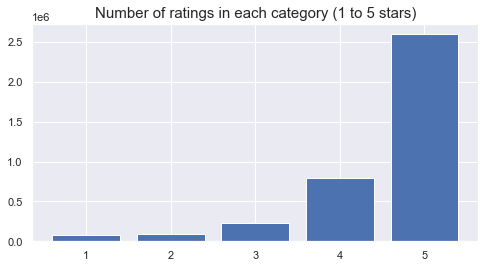

In [6]:
fig,ax=plt.subplots(figsize=(8,4))
plt.bar(ratings_count["Rating"],ratings_count["Count"]);
ax.set_title("Number of ratings in each category (1 to 5 stars)",fontsize=(15));

#### Do some user tend to be more severe than others ?

In [80]:
#Created a reviews table containing number 1,2,3,4,5 ratings for each user
users=pd.DataFrame(reviews["Reviewer_ID"].unique(),columns=["Reviewer_ID"])
users[1]=1

ratings=pd.DataFrame(reviews["Rating"].unique(),columns=["Rating"])
ratings[1]=1

reviews_table=pd.merge(users,ratings,on=1).drop(1,axis=1)
reviews_table=pd.merge(reviews_table,reviews.groupby(["Reviewer_ID","Rating"]).size().reset_index(),on=["Reviewer_ID","Rating"],how="left").fillna(0)
reviews_table=reviews_table.rename(columns={0 : "Counts"})

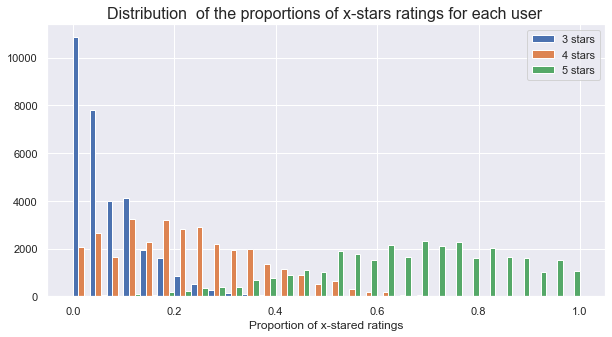

In [108]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
rating_dist=[(reviews_table[reviews_table["Rating"]==i].groupby("Reviewer_ID")["Counts"].sum()/reviews_table.groupby("Reviewer_ID")["Counts"].sum()) for i in range(3,6)]
ax.hist(rating_dist, label=["3 stars","4 stars","5 stars"],stacked=False,bins=30,rwidth=200);
ax.legend();
ax.set_xlabel("Proportion of x-stared ratings",fontsize=12);
ax.set_ylabel("Number of users",fontsize=12);
ax.set_title("Distribution  of the proportions of x-stars ratings for each user ",fontsize=16);


In [7]:
review_count_cut=review_count[review_count.between(review_count.quantile(0),review_count.quantile(0.8))]
ratings_cut=ratings_mean[review_count.between(review_count.quantile(0),review_count.quantile(0.8))]

#### Is the average rating of a recipe correlated to its numbe of reviews ?

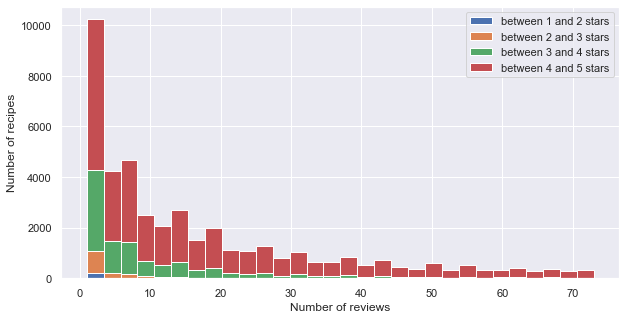

In [117]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
classes=[review_count_cut[ratings_cut.between(i,i+1)] for i in np.linspace(1,4,4)]
ax.hist(classes, label=["between 1 and 2 stars","between 2 and 3 stars","between 3 and 4 stars","between 4 and 5 stars"],stacked=True,bins=30);
#sns.scatterplot(review_count,ratings,ax=ax[1]);
ax.legend();
ax.set_xlabel("Number of reviews", fontsize=12);
ax.set_ylabel("Number of recipes",fontsize=12);

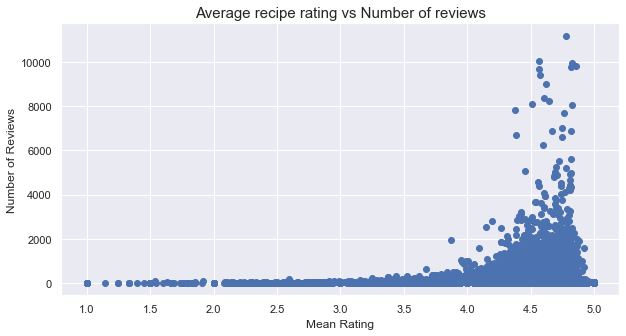

In [127]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
plt.scatter(ratings_mean,review_count);
ax.set_xlabel("Mean Rating", fontsize=12);
ax.set_ylabel("Number of Reviews",fontsize=12);
ax.set_title("Average recipe rating vs Number of reviews",fontsize=15);

#### Are some ingredients tastier than others  ?

In [9]:
from gensim.corpora import Dictionary

#Define Dictionary of Ingredients
dictionary = Dictionary(recipes["Ingredients_clean"])

#Fiter Ingredients that appear in at least 10 recipes
dictionary.filter_extremes(no_below=10,no_above=1)

In [10]:
len(dictionary)

1489

In [131]:
#Define Ingredient matrix : one-hot encode which ingredient appears in which recipe
ingredient_matrix=gensim.matutils.corpus2dense([dictionary.doc2bow(recipe) for recipe in recipes["Ingredients_clean"]], num_terms=len(dictionary))
ingredient_matrix=ingredient_matrix.T
ingredient_matrix=pd.DataFrame(ingredient_matrix,index=recipes["Recipe_ID"],columns=list(dictionary.token2id.keys()))

In [132]:
ingredient_matrix.head()

,baking powder,baking soda,basil,buttermilk,cheese,corn,cornmeal,egg,flour,onion,...,coconut water,sriracha,sriracha sauce,vanilla protein powder,gluten free,ritz cracker,sriracha hot,sriracha hot sauce,coconut sugar,diamond salt
Recipe_ID,,,,,,,,,,,,,,,,,,,,,
6664,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6666,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#Define ingredient rating : average rating of all recipes in which the ingredient appears
ingredient_count=ingredient_matrix.replace(0,np.nan).sum()
ingredient_ratings=ingredient_matrix.replace(0,np.nan).multiply(reviews.groupby("Recipe_ID")["Rating"].mean(),axis=0).mean()                                                                                                    

In [14]:
ingredient_ratings.sort_values(ascending=False)[:10]

anaheim chile pepper          4.763165
ritz cracker                  4.756381
pork back                     4.739394
baguette                      4.719352
ice cream                     4.713101
dry italian salad dressing    4.712435
duck                          4.696793
strawberry glaze              4.696481
cremini mushroom              4.672118
pink                          4.667532
dtype: float64

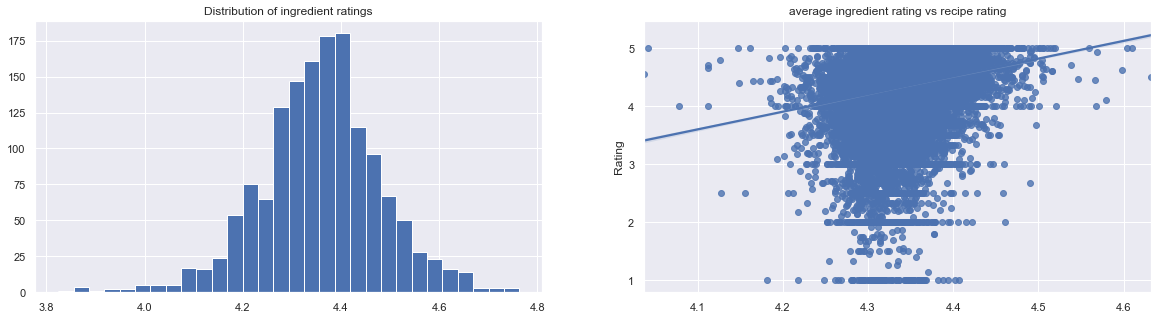

In [15]:
fig,ax=plt.subplots(1,2,figsize=(20,5));
ax[0].hist(ingredient_ratings,bins=30);
sns.regplot((ingredient_matrix*ingredient_ratings).replace(0,np.nan).mean(axis=1),ratings_mean,ax=ax[1]);

ax[0].set_title("Distribution of ingredient ratings");
ax[1].set_title("average ingredient rating vs recipe rating");

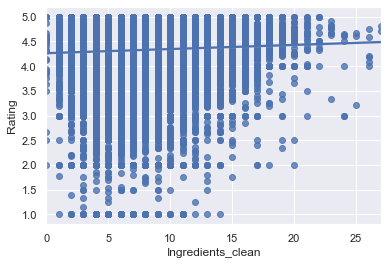

In [16]:
sns.regplot(recipes["Ingredients_clean"].apply(lambda x : len(x)),recipes["Rating"]);

In [17]:
(ratings_mean>4.8).sum()/len(ratings_mean)

0.1115748355263158

In [18]:
ratings_mean

Recipe_ID
6663      4.431818
6664      4.468085
6665      3.598837
6666      4.707865
6667      4.344828
            ...   
258753    5.000000
258755    5.000000
258771    4.000000
258773    5.000000
258790    3.000000
Name: Rating, Length: 48640, dtype: float64

In [19]:
significant_ingredients=ingredient_ratings[~ingredient_ratings.between(0,ingredient_ratings.mean()+ingredient_ratings.std())]

In [20]:
significant_ingredients.sort_values(ascending=False)

anaheim chile pepper    4.763165
ritz cracker            4.756381
pork back               4.739394
baguette                4.719352
ice cream               4.713101
                          ...   
puff pastry             4.483278
popcorn                 4.483231
feta cheese             4.482324
skirt steak             4.482309
tortilla                4.481861
Length: 204, dtype: float64

In [21]:
g=reviews[reviews["Recipe_ID"].isin(ratings_mean[ingredient_matrix[significant_ingredients.index].sum(axis=1)>1].index)]

In [22]:
(g.groupby("Recipe_ID")["Rating"].mean().sort_values(ascending=False)>4.8).sum()/len(g.groupby("Recipe_ID")["Rating"].mean())

0.3281786941580756

In [23]:
g.groupby("Recipe_ID")["Rating"].mean().sort_values(ascending=False)

Recipe_ID
220817    5.000000
172708    5.000000
233248    5.000000
239135    5.000000
232904    5.000000
            ...   
13816     3.750000
230370    3.714286
238129    3.500000
155891    3.456140
71691     3.357143
Name: Rating, Length: 582, dtype: float64

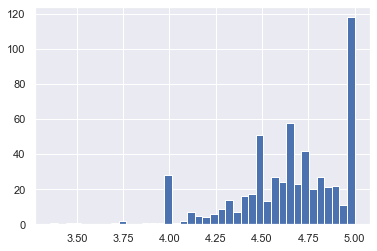

In [24]:
plt.hist(g.groupby(["Recipe_ID"])["Rating"].mean(),bins=40);

In [308]:
#Apply pca to X in order to plot clusters
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(ingredient_matrix)
recipe_matrix_reduced=pca.transform(ingredient_matrix)

In [309]:
kmeans = KMeans(n_clusters=100, random_state=0).fit(recipe_matrix_reduced)
recipe_matrix_reduced=pd.DataFrame(recipe_matrix_reduced)
recipe_matrix_reduced["label"]=kmeans.labels_

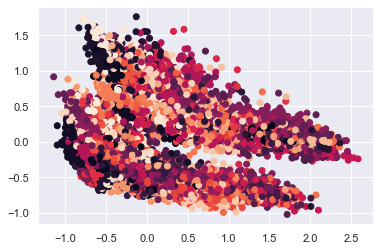

In [310]:
#plot clusters
plt.scatter(recipe_matrix_reduced.iloc[:,0],recipe_matrix_reduced.iloc[:,1],c=recipe_matrix_reduced["label"]);

#### Ingredient segmentation based on their co-occurences in recipes

In [25]:
#Define Ingredient matrix : one-hot encode which ingredient appears in which recipe
from gensim.matutils import corpus2csc
ingredient_matrix=gensim.matutils.corpus2csc([dictionary.doc2bow(recipe) for recipe in recipes["Ingredients_clean"]], num_terms=len(dictionary))

In [26]:
#Define coocurrence matrix
import sklearn
term_term_matrix=np.dot(ingredient_matrix, ingredient_matrix.T)

#Cosine similarity
X=pd.DataFrame(sklearn.metrics.pairwise.cosine_similarity(term_term_matrix))
X.columns=dictionary.token2id.keys()
X.index=dictionary.token2id.keys()

In [27]:
#roughly evelatuate number of clusters with elbow method
from sklearn.cluster import KMeans
inertia=[]
for i in range(1,20) : 
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    inertia.append(kmeans.inertia_)

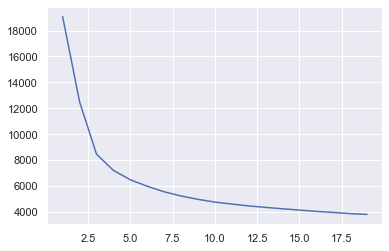

In [28]:
plt.plot([i for i in range(1,20)],inertia)

In [29]:
# apply kmeans on chosen number of clusters
kmeans = KMeans(n_clusters=30, random_state=0).fit(X)

In [30]:
#Apply pca to X in order to plot clusters
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
to_plot=pca.transform(X)

In [31]:
to_plot=pd.DataFrame(to_plot)
to_plot["label"]=kmeans.labels_
to_plot.columns=["X","Y","label"]

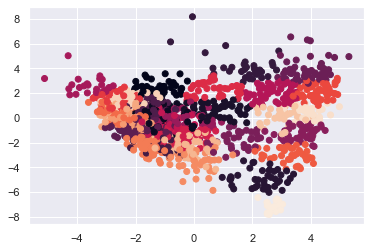

In [32]:
#plot clusters
plt.scatter(to_plot["X"],to_plot["Y"],c=to_plot["label"]);

In [33]:
X["label"]=kmeans.labels_

In [34]:
X[X["label"]==10].index

Index(['lemon cake', 'coffee liqueur', 'pistachio pudding', 'vanilla wafer',
       'chocolate sandwich cooky', 'whipped', 'chocolate cake',
       'irish cream liqueur', 'chocolate syrup', 'creme de menthe liqueur',
       'graham cracker', 'chocolate pudding', 'vanilla yogurt',
       'bar chocolate', 'caramel ice cream topping', 'amaretto liqueur',
       'ladyfinger', 'strawberry cake mix', 'vanilla frosting',
       'cream of coconut', 'hazelnut liqueur', 'bar milk chocolate',
       'blueberry pie filling', 'vanilla ice', 'tea powder',
       'crispy rice cereal', 'vanilla bean', 'white corn syrup',
       'chocolate candy', 'peppermint', 'maraschino cherry juice',
       'vanilla wafer cooky', 'lemon curd', 'pumpkin pie filling', 'syrup',
       'strawberry yogurt', 'irish whiskey', 'graham cracker pie', 'berry',
       'whipped topping', 'chocolate mix', 'food', 'green tea',
       'vanilla powder', 'fruit pectin', 'green tea powder'],
      dtype='object')

In [35]:
from sklearn.neighbors import NearestNeighbors
KNN=NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X)

In [36]:
list(KNN.kneighbors(X)[1][112])

[112, 677, 614, 210, 944, 1049, 1141, 1113, 194, 1176]

In [341]:
recipe_matrix=ingredient_matrix*X["label"]

In [343]:
#Apply pca to X in order to plot clusters
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(recipe_matrix)
recipe_matrix_reduced=pca.transform(recipe_matrix)

([<matplotlib.lines.Line2D at 0x15cfd76d8>],)

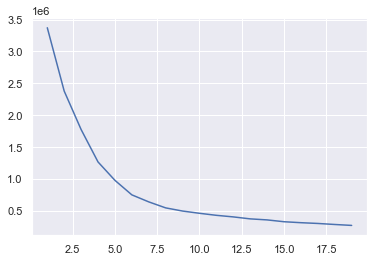

In [344]:
#roughly evelatuate number of clusters with elbow method
from sklearn.cluster import KMeans
inertia=[]
for i in range(1,20) : 
    kmeans = KMeans(n_clusters=i, random_state=0).fit(recipe_matrix_reduced)
    inertia.append(kmeans.inertia_)

plt.plot([i for i in range(1,20)],inertia),

In [349]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(recipe_matrix_reduced)
recipe_matrix_reduced=pd.DataFrame(recipe_matrix_reduced)
recipe_matrix_reduced["label"]=kmeans.labels_

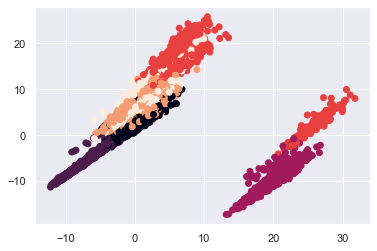

In [350]:
#plot clusters
plt.scatter(recipe_matrix_reduced.iloc[:,0],recipe_matrix_reduced.iloc[:,1],c=recipe_matrix_reduced["label"]);

In [351]:
recipe_matrix["label"]=kmeans.labels_

In [395]:
plot_recipes(recipe_matrix[recipe_matrix["label"]==1].index[200:220])

(array(['Images/7018.jpg', 'Images/7019.jpg', 'Images/7021.jpg',
        'Images/7023.jpg', 'Images/7024.jpg', 'Images/7025.jpg',
        'Images/7027.jpg', 'Images/7028.jpg', 'Images/7030.jpg',
        'Images/7033.jpg', 'Images/7034.jpg', 'Images/7037.jpg',
        'Images/7038.jpg', 'Images/7040.jpg', 'Images/7042.jpg',
        'Images/7043.jpg', 'Images/7044.jpg', 'Images/7045.jpg',
        'Images/7048.jpg', 'Images/7049.jpg'], dtype='<U15'),
 array(['Angel Biscuits II', 'Fudgy Chocolate Chip Muffins',
        'Indian Naan II', 'Chocolate Chocolate Chip Muffins',
        'Banana Nut Bread Baked in a Jar', 'Light Oat Bread',
        'Potato Bread III', 'French Baguettes', 'Oatmeal Soda Bread',
        "Mary Anne's Moist and Nutty Carrot Loaf", 'Russian Black Bread',
        'Angel Biscuit Rolls', 'Panettone II', "J.P.'s Big Daddy Biscuits",
        'Paska Bread', 'Bread Machine Challah I', 'Pumpkin Bread V',
        'Best Ever Cinnamon Buns', 'Zucchini Pineapple Bread I',
        '

In [355]:
reviews=pd.merge(recipe_matrix["label"].reset_index(),reviews,on="Recipe_ID",how="right")

In [377]:
user_matrix=reviews.groupby(["Reviewer_ID","label"]).size().reset_index().pivot(index="Reviewer_ID",columns="label",values=0).fillna(0)
user_matrix=user_matrix.divide(user_matrix.sum(axis=1),axis=0)

In [378]:
#Apply pca to X in order to plot clusters
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(user_matrix)
user_matrix_reduced=pca.transform(user_matrix)

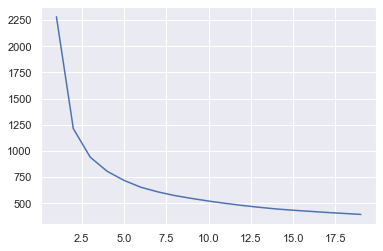

In [379]:
#roughly evelatuate number of clusters with elbow method
from sklearn.cluster import KMeans
inertia=[]
for i in range(1,20) : 
    kmeans = KMeans(n_clusters=i, random_state=0).fit(user_matrix_reduced)
    inertia.append(kmeans.inertia_)
    
plt.plot([i for i in range(1,20)],inertia)

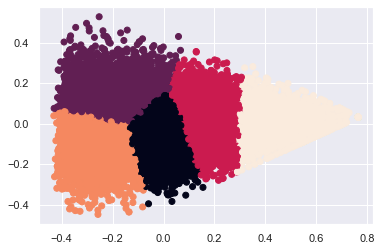

In [380]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(user_matrix_reduced)
user_matrix_reduced=pd.DataFrame(user_matrix_reduced)
user_matrix_reduced["label"]=kmeans.labels_

#plot clusters
plt.scatter(user_matrix_reduced.iloc[:,0],user_matrix_reduced.iloc[:,1],c=user_matrix_reduced["label"]);

In [383]:
pca.explained_variance_ratio_

array([0.70149825, 0.16201317, 0.06950392, 0.0493166 , 0.01766806])

In [381]:
pca.components_

array([[-0.33902415,  0.88044398, -0.11394676, -0.10280676, -0.2919939 ,
        -0.03267241],
       [-0.75264314, -0.05849948,  0.08057815,  0.03586328,  0.64820125,
         0.04649993],
       [-0.3621692 , -0.18600675,  0.45171694,  0.59129308, -0.52860104,
         0.03376697],
       [-0.01519781, -0.01011941,  0.7515825 , -0.65496321, -0.07609583,
         0.00479376],
       [-0.14327165, -0.14152251, -0.21197211, -0.20705945, -0.20663592,
         0.91046165]])

#### Content-based recommender system (using ingredients only)

In [37]:
def index_to_id(index_list) :
    id_list=[]
    for index in index_list :
        id_list.append(recipes["Recipe_ID"].iloc[index])
    return id_list

import ipyplot

In [38]:
recipes.iloc[800]["Recipe_name"]

'Cheesecake Supreme'

In [179]:
def plot_recipes(recipe_list) :
    images=[]
    labels=[]
    for recipe_ID in recipe_list :
        images.append("Images/{}.jpg".format(recipe_ID))
        labels.append(recipes[recipes["Recipe_ID"]==recipe_ID]["Recipe_name"].iloc[0])
        #labels.append(recipes.iloc[recipe_ID]["Recipe_name"])
          
    images=np.array(images)
    labels=np.array(labels)
    
    ipyplot.plot_images(images, labels=labels,max_images=100, img_width=150);
    
    return(images,labels)
    

In [40]:
bow_corpus = [dictionary.doc2bow(ingredients) for ingredients in recipes["Ingredients_clean"]]

In [41]:
from gensim.models import TfidfModel
model=TfidfModel(bow_corpus)

In [42]:
from gensim.similarities import MatrixSimilarity
index = MatrixSimilarity(model[bow_corpus], num_features=len(dictionary))

In [43]:
plot_recipes(index_to_id(index[bow_corpus[100]].argsort()[-20:][::-1]));

In [44]:
plot_recipes(index_to_id(index[bow_corpus[5000]].argsort()[-20:][::-1]));

#### Collaborative filtering recommender system (using ingredients only)

In [45]:
#keep only recipes with more than 10 reviews
mask=reviews.groupby("Recipe_ID").size()[reviews.groupby("Recipe_ID").size()>30].index
reviews=reviews[reviews["Recipe_ID"].isin(mask)]
recipes=recipes[recipes["Recipe_ID"].isin(mask)]

In [46]:
#Keep only users with more than 8 reviews
mask=reviews.groupby("Reviewer_ID").size()[reviews.groupby("Reviewer_ID").size()>15].index
reviews=reviews[reviews["Reviewer_ID"].isin(mask)]
recipes=recipes[recipes["Recipe_ID"].isin(reviews["Recipe_ID"].unique())]

In [47]:
reviews.groupby("Reviewer_ID").size()

Reviewer_ID
22           22
32           56
39          237
138          30
148          28
           ... 
22386021     53
22404317     19
22450440     23
22585119     22
23104477     20
Length: 32280, dtype: int64

In [48]:
reviews.groupby("Recipe_ID").size()

Recipe_ID
6663       23
6664       27
6665       26
6666      130
6667       44
         ... 
257198      7
257206     13
257938     34
258117     15
258468      8
Length: 18194, dtype: int64

In [56]:
from sklearn.model_selection import train_test_split
Recipe_ids_train,Recipe_ids_test=train_test_split(recipes["Recipe_ID"],test_size=0.25,random_state=42)

In [57]:
reviews_train=reviews[reviews["Recipe_ID"].isin(Recipe_ids_train)]
reviews_test=reviews[reviews["Recipe_ID"].isin(Recipe_ids_test)]

In [58]:
users_reviews_pivot_matrix = reviews_train.pivot(index='Reviewer_ID', columns='Recipe_ID', values='Rating').fillna(0)

In [59]:
users_reviews_pivot_matrix.head()

Recipe_ID,6663,6665,6667,6670,6672,6674,6675,6676,6677,6680,...,255423,255823,255886,255936,256864,257054,257198,257206,257938,258468
Reviewer_ID,,,,,,,,,,,,,,,,,,,,,
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
user_similarity_matrix=cosine_similarity(users_reviews_pivot_matrix)

In [ ]:
reviews["Reviewer_ID"]==users_reviews_pivot_matrix.index[user_similarity_matrix[0].argsort()[-20:][::-1][1]]

In [ ]:
def index_to_recipe_id(index_list) :
    id_list=[]
    for index in index_list :
        id_list.append(recipes["Recipe_ID"].iloc[index])
    return id_list

import ipyplot

In [ ]:
index_to_id([2262])[0]

In [ ]:
# from scipy.sparse import csr_matrix
from  scipy.sparse import csr_matrix
users_reviews_pivot_sparse_matrix = csr_matrix(users_reviews_pivot_matrix)

In [ ]:
from scipy.sparse.linalg import svds
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

U, sigma, Vt = svds(users_reviews_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [ ]:
U.shape

In [ ]:
Vt.shape

In [ ]:
sigma = np.diag(sigma)
sigma.shape

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

In [ ]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_reviews_pivot_matrix.columns, index=users_reviews_pivot_matrix.index).transpose()

In [ ]:
cf_preds_df[240].sort_values(ascending=False).index[:10]

In [ ]:
cf_preds_df

In [ ]:
users_reviews_pivot_matrix.loc[22][users_reviews_pivot_matrix.loc[22]!=0].index

In [ ]:
plot_recipes(users_reviews_pivot_matrix.loc[32][users_reviews_pivot_matrix.loc[32]!=0].index);